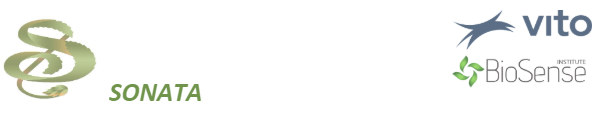
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### Create some simple evaluation metrics for the generated habitat maps

#### Area distribution per habitat class

##### if the maps are already cut to study area, we don't need the study area shapefile anymore

In [64]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
def compute_habitat_area(raster_path, lut_path, pixel_size=10):
    """
    Computes the area in hectares for each unique habitat class in the raster.

    Parameters:
    raster_path (str): Path to the classified habitat raster map.
    lut_path (str): Path to the Look Up Table (LUT) Excel file.
    pixel_size (int, optional): Size of each pixel in meters (default is 10m).

    Returns:
    pd.DataFrame: DataFrame with habitat classes and their respective areas in hectares.
    """
    # Read the raster data
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the first band

    # Read the LUT file
    lut = pd.read_excel(lut_path)
    lut["raster_value"] = lut["raster_value"].astype(int)

    # Compute the area of each unique class
    unique, counts = np.unique(raster_data, return_counts=True)

    # Convert pixel count to hectares (1 hectare = 10,000 square meters)
    pixel_area_ha = (pixel_size ** 2) / 10000  # Convert square meters to hectares
    area_dict = {int(code): count * pixel_area_ha for code, count in zip(unique, counts)}

    # Create a DataFrame
    area_df = pd.DataFrame(area_dict.items(), columns=["RasterValue", "Area_Ha"])

    # Merge with LUT to get habitat labels
    area_df = area_df.merge(lut[['eunis_code', 'raster_value']], left_on='RasterValue',
                            right_on='raster_value', how='left')
    area_df = area_df.drop(columns=['raster_value'])

    area_df = area_df.dropna(subset=["eunis_code"])

    # save output
    #output_csv = f"/data/habitat/serbia/inference/Continental/2024/merge_levels/CON_habitat-map_L{level}_area.csv"
    #area_df.to_csv(output_csv, index=False)

    return area_df

In [66]:
def plot_habitat_distribution(area_df, label_col, area_col, level, split = False):
    """
    Plots a bar graph of habitat areas with labels on the x-axis.

    Parameters:
    area_df (pd.DataFrame): DataFrame containing habitat class labels and their area in hectares.
    label_col (str, optional): Column name for habitat labels.
    area_col (str, optional): Column name for habitat areas.
    """
    # Drop rows where label is NaN
    area_df = area_df.dropna(subset=[label_col])

    area_df[label_col] = area_df[label_col].astype(str)

    if split and level in [2, 3]:
        # Group by first letter of the label
        area_df["Group"] = area_df[label_col].str[0]
        groups = area_df["Group"].unique()

        for group in sorted(groups):
            subset = area_df[area_df["Group"] == group]
            plt.figure(figsize=(12, 6))
            plt.bar(subset[label_col], subset[area_col], color='orange')
            plt.xlabel(f"EUNIS habitat level {level}")
            plt.ylabel("Area [ha]")
            plt.xticks(rotation=0, ha='right')
            plt.title(f"Area distribution for EUNIS level {level} habitat type within group {group}")
            plt.gca().set_facecolor("white")  # Set background to white
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            #graph_path = f"/data/habitat/serbia/inference/Continental/2024/merge_levels/output/habitat_level{level}_distribution_group_{group}.png"
            #plt.savefig(graph_path, dpi=300)
            plt.show()
    else:
        plt.figure(figsize=(12, 6))
        plt.bar(area_df[label_col], area_df[area_col], color='orange')
        plt.xlabel(f"EUNIS habitat level {level}")
        plt.ylabel("Area [ha]")
        plt.xticks(rotation=0, ha='right')
        plt.title(f"Area distribution for EUNIS level {level} habitat types")
        plt.gca().set_facecolor("white")  # Set background to white
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        #graph_path = f"/data/habitat/serbia/inference/Continental/2024/merge_levels/output/habitat_level{level}_distribution_group_{group}.png"
        #plt.savefig(graph_path, dpi=300)
        plt.show()


#### Specify input

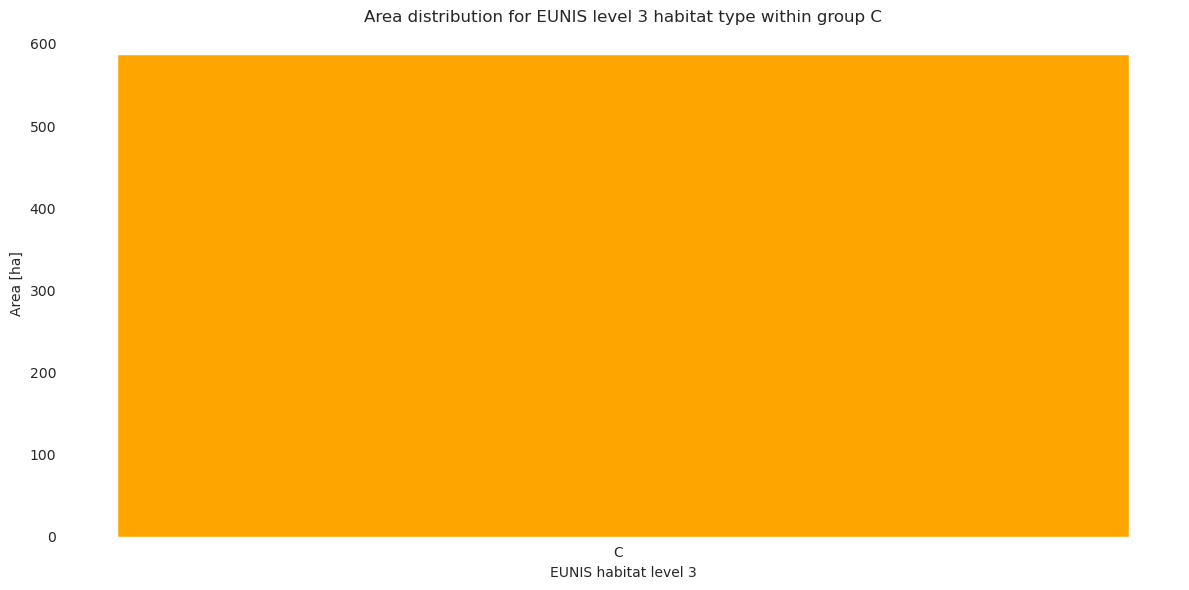

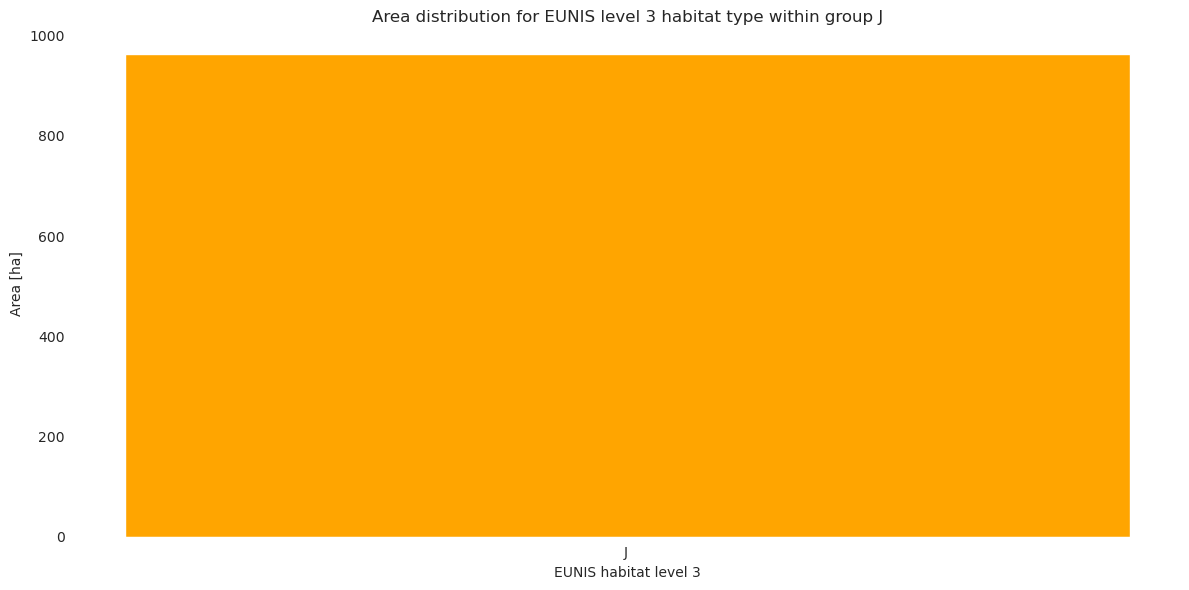

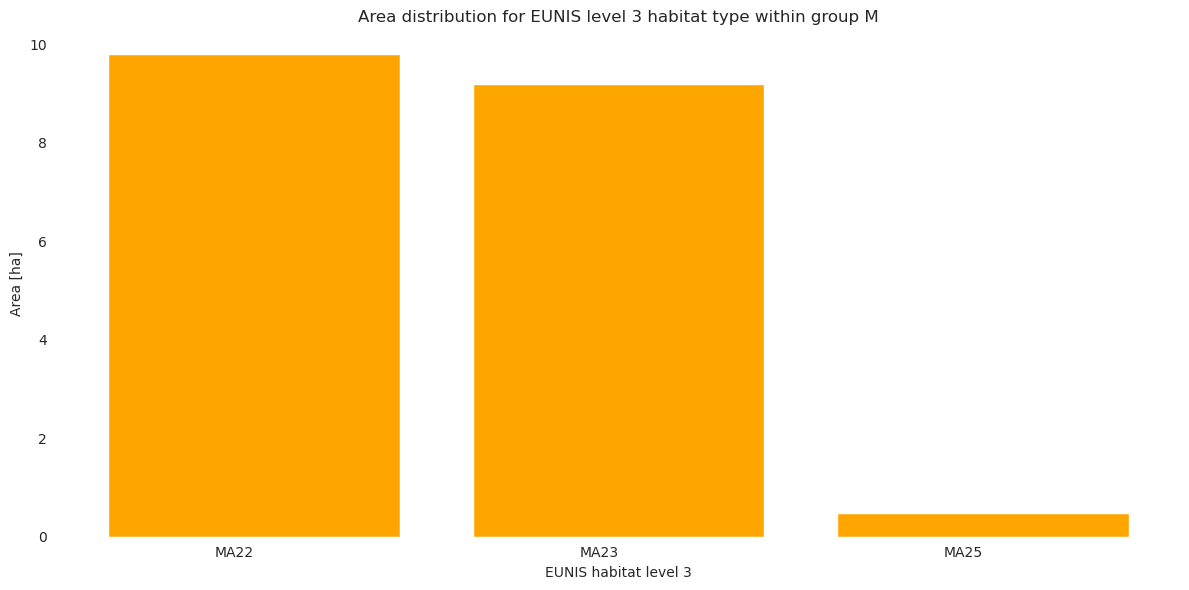

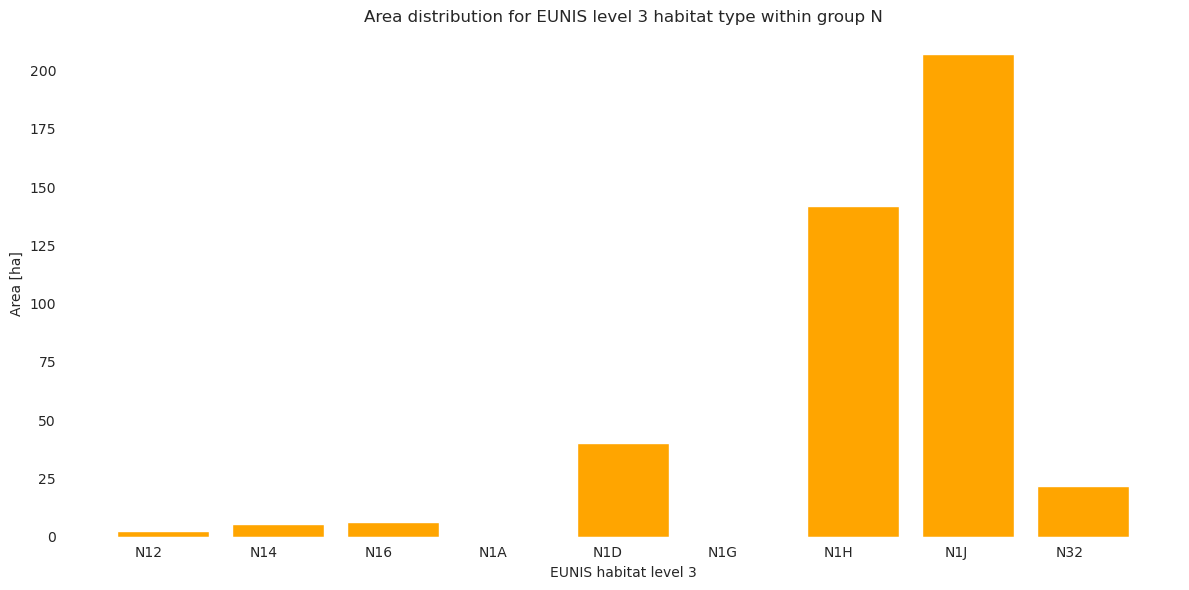

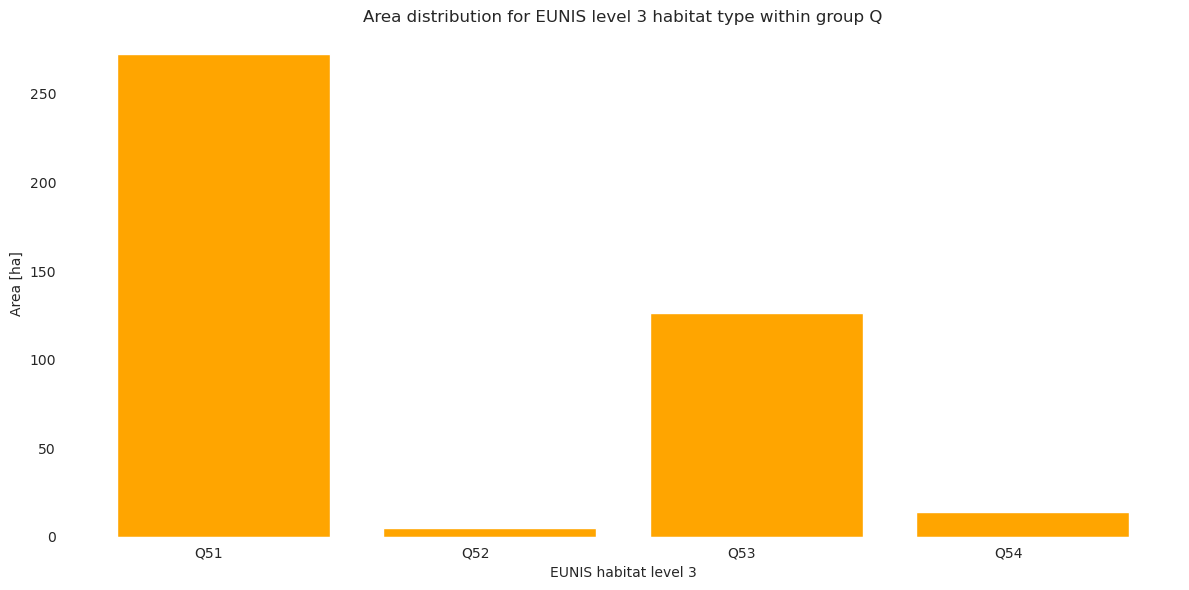

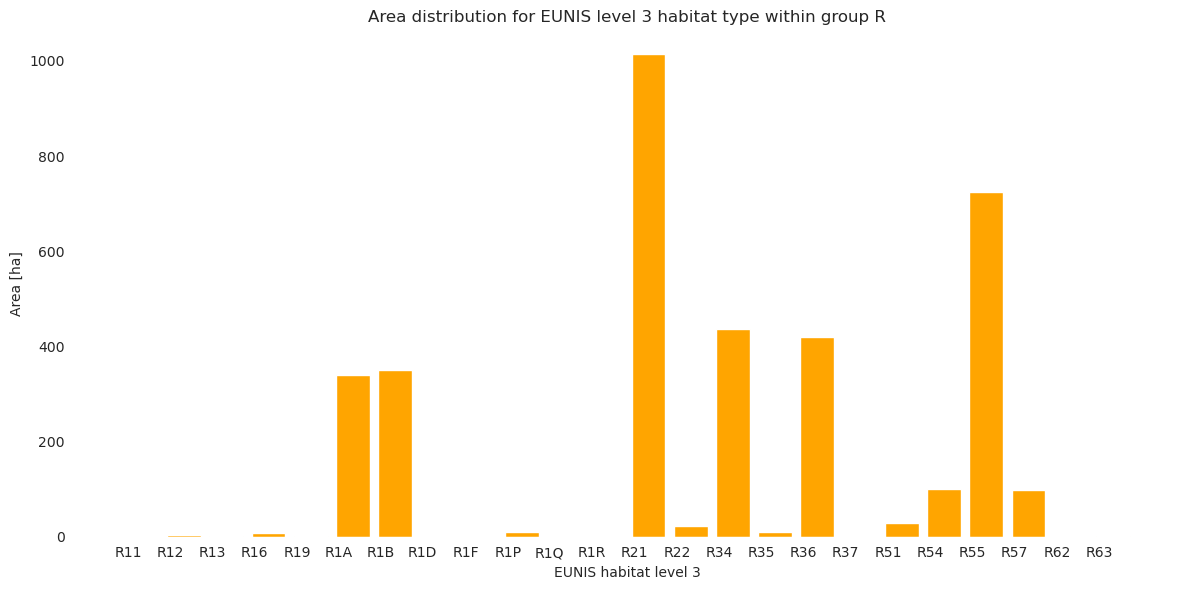

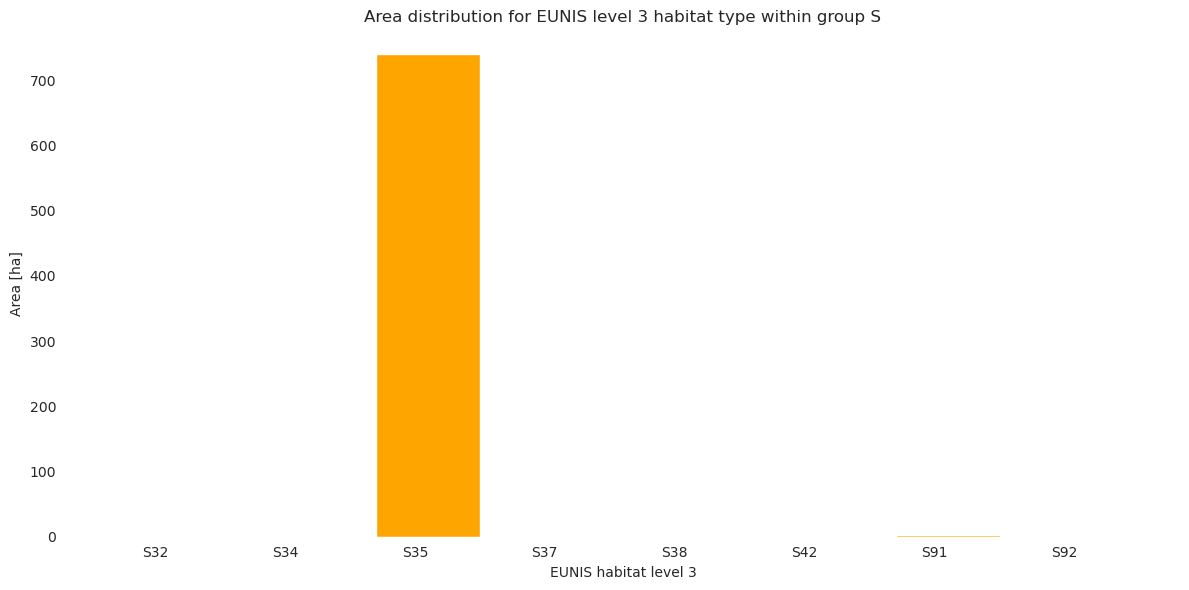

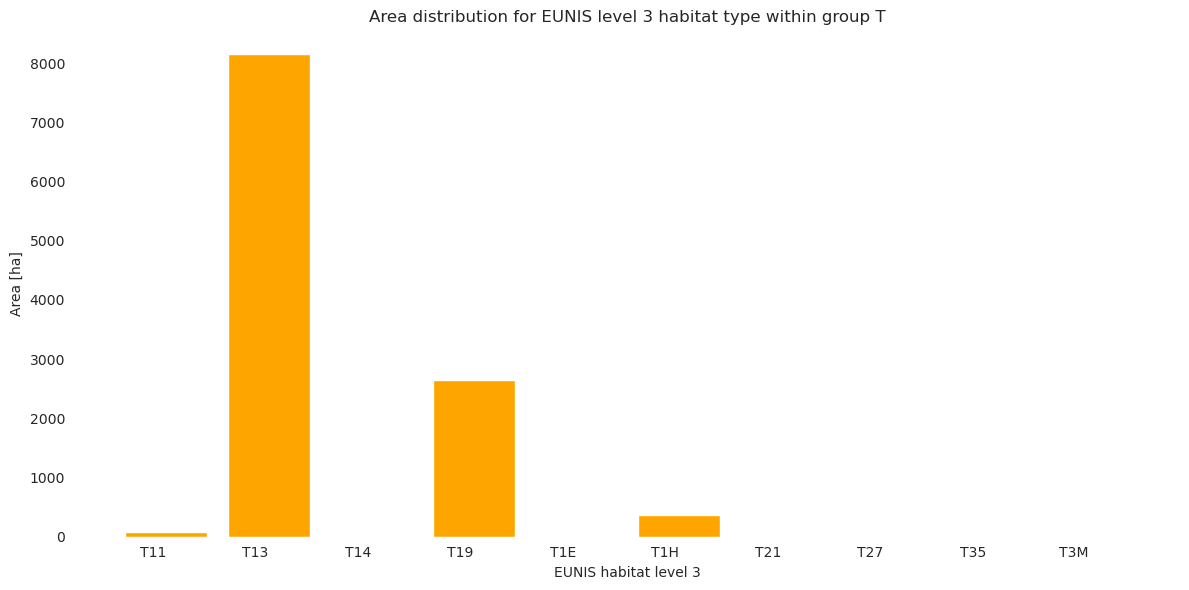

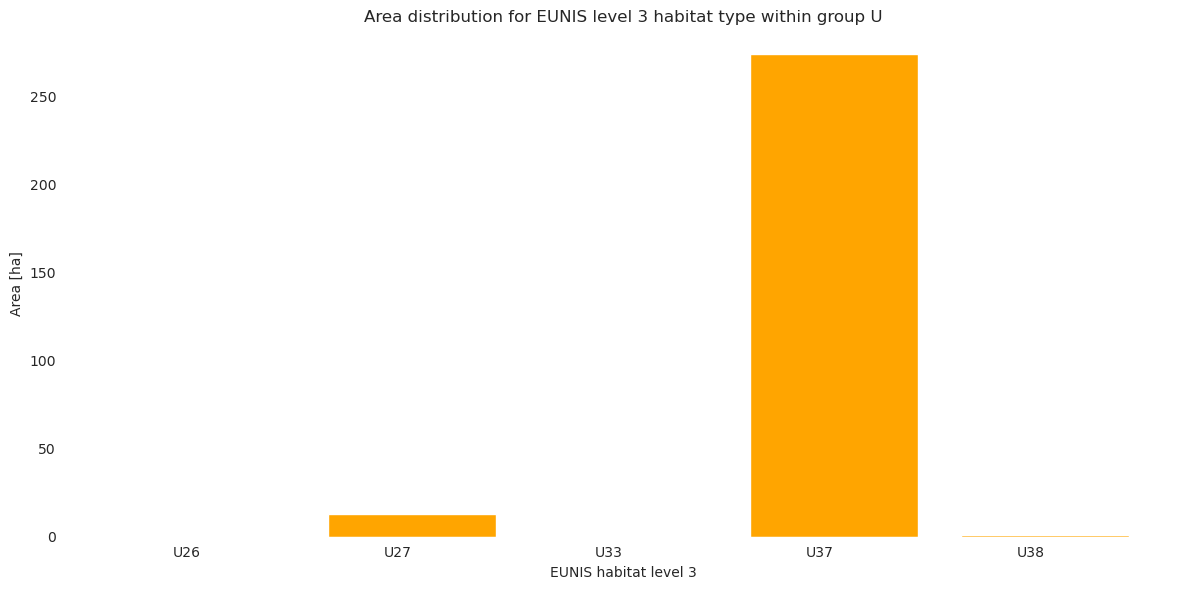

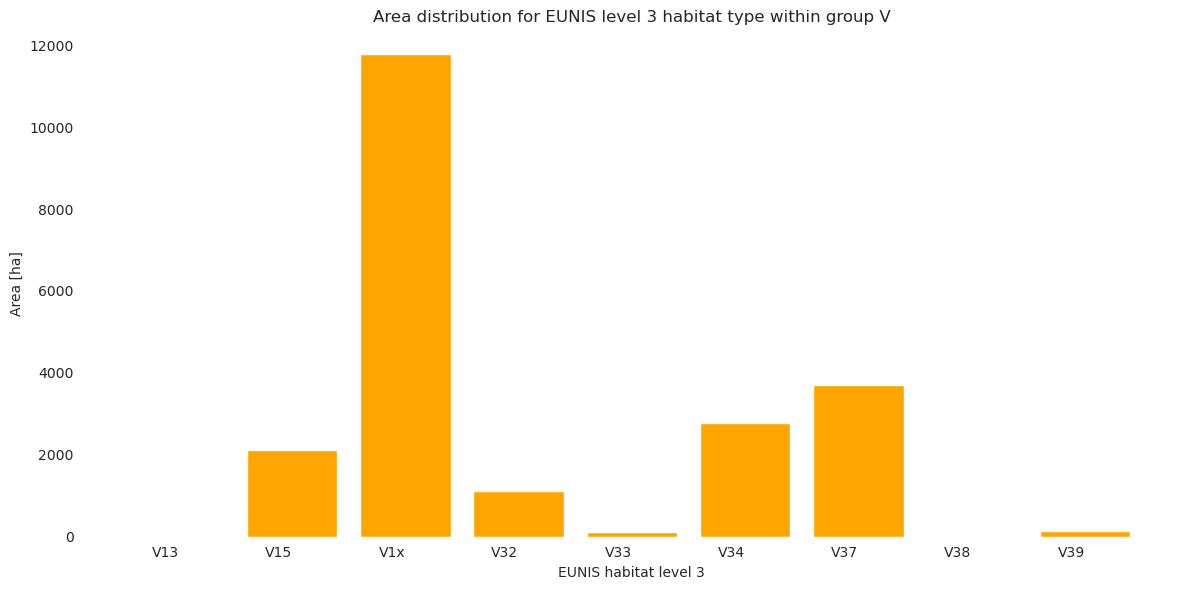

<bound method NDFrame.head of     RasterValue  Area_Ha eunis_code
1         10202     9.79       MA22
2         10203     9.19       MA23
3         10205     0.49       MA25
4         40102     2.32        N12
5         40104     5.49        N14
..          ...      ...        ...
70       100307  3696.51        V37
71       100308     9.77        V38
72       100309   128.51        V39
73       110000   587.24          C
74       120000   962.27          J

[74 rows x 3 columns]>


In [71]:
level = 3
raster_path = f"/data/habitat/serbia/inference/Continental/2024/merge_levels/CON_habitat-map_L{level}_tile.tif"
lut_path = "./data/LUT_topology_EUNIS2021plus_v1.xlsx"
area_df = compute_habitat_area(raster_path, lut_path)
plot_habitat_distribution(area_df, label_col=f"eunis_code", area_col="Area_Ha", level=level, split = True)
print(area_df.head)